Epoch 1/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.8231 - loss: 0.3948 - val_accuracy: 0.9384 - val_loss: 0.1506 - learning_rate: 1.0000e-04
Epoch 2/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.9285 - loss: 0.1741 - val_accuracy: 0.9531 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 3/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.9426 - loss: 0.1462 - val_accuracy: 0.9587 - val_loss: 0.1092 - learning_rate: 1.0000e-04
Epoch 4/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 71s 78ms/step - accuracy: 0.9464 - loss: 0.1394 - val_accuracy: 0.9541 - val_loss: 0.1124 - learning_rate: 1.0000e-04
Epoch 5/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.9513 - loss: 0.1251 - val_accuracy: 0.9584 - val_loss: 0.1057 - learning_rate: 1.0000e-04
Epoch 6/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.9524 - loss: 0.1225 - val_accuracy: 0.9622 - val_loss: 0.0988 - learning_rate: 1.0000e-04
Epoch 7/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 103s 69ms/st

907/907 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.9726 - loss: 0.0699 - val_accuracy: 0.9699 - val_loss: 0.0823 - learning_rate: 2.5000e-05
Epoch 47/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.9730 - loss: 0.0709 - val_accuracy: 0.9709 - val_loss: 0.0799 - learning_rate: 2.5000e-05
Epoch 48/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9723 - loss: 0.0691 - val_accuracy: 0.9708 - val_loss: 0.0804 - learning_rate: 2.5000e-05
Epoch 49/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.9713 - loss: 0.0724 - val_accuracy: 0.9693 - val_loss: 0.0802 - learning_rate: 2.5000e-05
Epoch 50/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.9727 - loss: 0.0695 - val_accuracy: 0.9704 - val_loss: 0.0807 - learning_rate: 2.5000e-05
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9739 - loss: 0.0822
Test Accuracy: 97.34%
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
[[8938  134]
 [ 349 8712]]
              precision    recall  f1-score   suppor

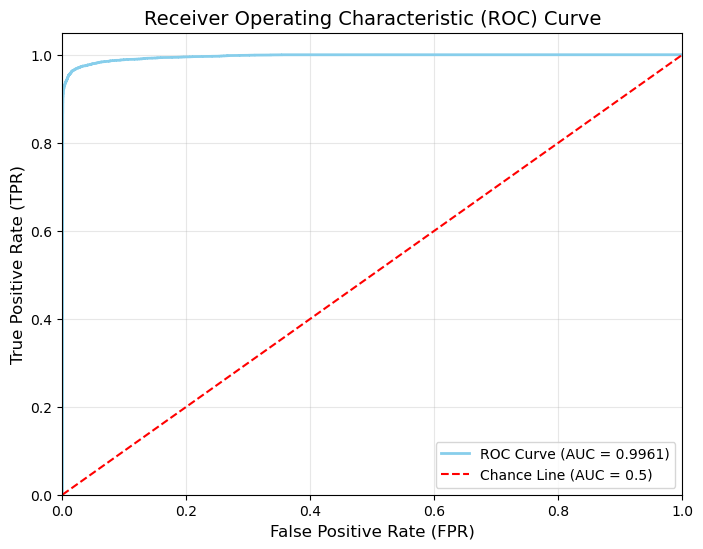

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
data = pd.read_csv('UNSW_NB15.csv')

# Drop irrelevant features
data = data.drop(['id', 'attack_cat'], axis=1)

# Separate features and labels
X = data.drop('label', axis=1)  # 'label' is the target feature (0: Normal, 1: Attack)
y = data['label']

# Encode categorical features
categorical_columns = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Apply KMeans Clustering
n_clusters = len(y_resampled.unique())
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_resampled)

# Append KMeans cluster labels as a new feature
X_resampled = pd.DataFrame(X_resampled)
X_resampled['cluster'] = kmeans_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape the input data for CNN
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = models.Sequential()

# Input Layer
model.add(layers.Input(shape=(X_train.shape[1], 1)))

# Convolutional Layers with Batch Normalization
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Layers with Dropout
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer (Binary Classification)
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add Callbacks: Early Stopping and Learning Rate Scheduler
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the Model
model.save('nids_cnn_kmeans_model_optimized.keras')

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion Matrix and Classification Report
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance Line (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [2]:
print(X_resampled['cluster'].unique())



[0 1]
